## FORCE-2020: Machine Predicted Lithology

By: Jeremy Zhao

This is my very first machine learning submission. This challenge was to take data provided by Xeek to predict the lithology from well logs. There was a training set and a test set that was provided, along with a custom penalty matrix provided by Xeek. In the training and test set, the lithology was interpreted manually in order to see how close the machine algorithm would get. 

This particular Jupyter notebook is derived from the starter notebook as it was my first time with machine learning. I have also added many references in order to help myself learn more about machine learning. I hope this may be of help to those who are just starting to learn ML like I did, and to see the struggles I went through.

### Credit Information

Lithofacies data was provided by the FORCE Machine Learning competition with well logs and seismic 2020

Bormann P., Aursand P., Dilib F., Dischington P., Manral S. 2020. 2020 FORCE Machine Learning Contest. https://github.com/bolgebrygg/Force-2020-Machine-Learning-competition

### 1. Importing Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

import time
import operator
import missingno
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import power_transform
from sklearn.inspection import permutation_importance
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import RidgeClassifier

import featuretools as ft

#import xgboost as xgb
#from xgboost.sklearn import XGBClassifier

### 2. Load training data

In [2]:
data = pd.read_csv(r'train.csv', sep=';')
pd.options.display.max_columns = None

In [3]:
data

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.5280,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,1.798681,1.884186,80.200851,NaN,NaN,20.915468,161.131180,24.612379,NaN,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.6800,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,1.795641,1.889794,79.262886,NaN,NaN,19.383013,160.603470,23.895531,NaN,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.8320,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,1.800733,1.896523,74.821999,NaN,NaN,22.591518,160.173615,23.916357,NaN,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.9840,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,1.801517,1.891913,72.878922,NaN,NaN,32.191910,160.149429,23.793688,NaN,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
4,15/9-13,495.1360,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,1.795299,1.880034,71.729141,NaN,NaN,38.495632,160.128342,24.104078,NaN,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170506,7/1-2 S,3169.3124,NaN,NaN,NaN,VESTLAND GP.,Bryne Fm.,8.423170,NaN,NaN,NaN,2.527984,77.654900,NaN,NaN,4.586425,NaN,NaN,8.5,27.674368,NaN,NaN,-0.001763,NaN,NaN,26.673708,NaN,30000,2.0
1170507,7/1-2 S,3169.4644,NaN,NaN,NaN,VESTLAND GP.,Bryne Fm.,8.379244,NaN,NaN,NaN,2.537613,75.363937,NaN,NaN,7.019858,NaN,NaN,8.5,28.024338,NaN,NaN,-0.007600,NaN,NaN,26.840818,NaN,65030,2.0
1170508,7/1-2 S,3169.6164,NaN,NaN,NaN,VESTLAND GP.,Bryne Fm.,8.350248,NaN,NaN,NaN,2.491860,66.452843,NaN,NaN,9.049782,NaN,NaN,8.5,28.091282,NaN,NaN,-0.018297,NaN,NaN,27.007942,NaN,65030,2.0
1170509,7/1-2 S,3169.7684,NaN,NaN,NaN,VESTLAND GP.,Bryne Fm.,8.313779,NaN,NaN,NaN,2.447539,55.784817,NaN,NaN,8.903917,NaN,NaN,8.5,28.019775,NaN,NaN,-0.011438,NaN,NaN,27.175179,NaN,65030,2.0


In [4]:
data.sample(10)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
88709,16/10-3,1920.517599,460430.31250,6453747.0,-1880.387329,ROGALAND GP.,Lista Fm.,13.110950,0.516617,0.519686,0.603463,2.166190,91.668030,NaN,NaN,5.049998,129.487595,87.816154,12.250001,39.700001,NaN,0.991008,0.012113,0.167757,NaN,NaN,NaN,65000,1.0
199852,17/11-1,1398.049016,520153.18750,6452287.5,-1371.049072,SHETLAND GP.,Hod Fm.,13.105332,4.634409,3.376395,3.900920,2.450104,26.314533,NaN,0.148479,NaN,79.125534,30.889002,NaN,29.891888,NaN,NaN,-0.008249,1.168307,NaN,NaN,NaN,70032,1.0
103909,16/11-1 ST3,1652.977201,474584.59375,6436504.0,-1623.950684,SHETLAND GP.,Tor Fm.,12.650887,NaN,0.887320,0.604027,NaN,11.818420,NaN,NaN,NaN,88.316589,41.083427,12.250001,13.212258,NaN,NaN,NaN,1.162316,NaN,NaN,NaN,70032,2.0
183134,16/7-5,2609.583985,446270.37500,6468388.0,-2582.653564,VIKING GP.,Skagerrak Fm.,8.319789,0.594725,0.562036,0.370376,2.206233,40.574306,NaN,0.266853,3.918453,66.272774,61.171162,NaN,10.086158,NaN,NaN,-0.026926,1.330073,NaN,NaN,NaN,30000,1.0
388147,25/7-2,1696.720000,454805.21875,6571039.0,-1671.575562,HORDALAND GP.,Skade Fm.,18.930027,0.934750,0.616358,0.623533,2.100364,30.319147,NaN,NaN,NaN,142.798141,35.409088,17.500000,20.000000,NaN,1.647684,-0.025410,NaN,0.66877,NaN,0.655979,65000,1.0
876583,34/4-10 R,4048.178467,450935.84375,6832992.0,-4022.436523,SHETLAND GP.,Kyrre Fm.,8.472857,NaN,3.268561,3.969168,2.583423,104.104156,NaN,0.204639,6.136071,81.927910,NaN,8.500000,10.237500,156.760986,NaN,-0.021573,NaN,NaN,0.203935,NaN,65000,1.0
221141,25/11-5,1397.112719,463756.00000,6562935.0,-1373.612671,HORDALAND GP.,Skade Fm.,12.553437,NaN,0.805033,0.639763,2.197442,43.679905,NaN,0.575371,NaN,155.308456,49.933697,12.250001,69.826248,NaN,0.303437,-0.272000,1.126368,NaN,NaN,NaN,65000,2.0
698488,33/5-2,3995.864069,426954.40625,6837592.5,-3969.545166,VIKING GP.,Draupne Fm.,9.338177,11.061895,13.869134,5.258344,2.641514,258.304382,NaN,0.234706,NaN,90.511848,64.021454,8.500000,NaN,NaN,NaN,0.010716,NaN,NaN,NaN,NaN,65000,1.0
1130066,35/9-2,2801.264358,550268.50000,6800636.0,-2768.401123,DUNLIN GP.,Statfjord Fm.,8.403306,NaN,7.198225,10.876161,2.499469,83.516891,85.022713,0.095638,NaN,NaN,144.791458,8.500000,NaN,NaN,-0.096694,0.006528,NaN,NaN,NaN,NaN,30000,1.0
819866,34/11-2 S,1800.376000,466833.87500,6788245.5,-1775.142334,HORDALAND GP.,Utsira Fm.,17.668823,NaN,0.765920,0.965941,2.153285,94.177971,NaN,NaN,9.922971,139.756485,-2.062652,NaN,NaN,NaN,NaN,0.003016,NaN,NaN,25.612480,-999.000000,65000,1.0


### 3. Inspecting available logs and interpretations

The following is taken from the starter Jupyter notebook as a description of the available logs and its variable definitions.

*The data contains the metadata columns*
* *WELL: well name*
* *DEPTH_MD: measured depth*
* *X_LOC: UTM X coordinate* 
* *Y_LOC: UTM Y coordinate*
* *Z_LOC: DEPTH*
* *GROUP: NPD lithostratigraphy group*
* *FORMATION: NPD lithostratgraphy formation*

*The data contains the well log curves. For example the following:*
* *BS: Bit Size*
* *CALI: Caliper*
* *RDEP: Deep Resistivity*
* *RHOB: Bulk Density*
* *GR: Raw gamma data*
* *SGR: Spectral Gamma Ray*
* *RMED: Medium Resistivity*
* *ROP: Rate of Penetration*
* *NPHI: Neutron Porosity*
* *PEF: Photoelectric Absorption Factor*
* *RSHA: Shallow Resistivity*
* *DTS: Sonic (Sheer Slowness)*
* *DTC: Sonic (Compressional Slowness)*
* *FORCE_2020_LITHOFACIES_LITHOLOGY: lithology class label*
* *FORCE_2020_LITHOFACIES_CONFIDENCE: confidence in lithology interpretation (1: high, 2: medium, 3: low)*

*There is a total of 83 wells in the training dataset. The `WELL` column is included so the data can be separated per well. This will be necessary for any "windowed" approaches where we use non-local information in the ML features.* 

In [5]:
wells = data['WELL'].unique()

In [6]:
wells

array(['15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1',
       '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3', '16/2-11 A',
       '16/2-16', '16/2-6', '16/4-1', '16/5-3', '16/7-4', '16/7-5',
       '16/8-1', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5',
       '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/5-1',
       '25/5-4', '25/6-1', '25/6-2', '25/6-3', '25/7-2', '25/8-5 S',
       '25/8-7', '25/9-1', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S',
       '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9',
       '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5',
       '31/5-4 S', '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S',
       '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33',
       '34/10-35', '34/11-1', '34/11-2 S', '34/12-1', '34/2-4',
       '34/3-1 A', '34/4-10 R', '34/5-1 A', '34/5-1 S', '34/7-13',
       '34/7-20', '34/7-21', '34/8-1', '34/8-3', '34/8-7 R', '35/11-1',
       '35/11-10', '35/11-11', '35/11-12

In [7]:
len(wells)

98

### 4. Exploratory Data Analysis (EDA)

Exploratory Data Analysis or EDA is an initial first step in determining basic statistics about the data that you are dealing with. In particular, with added knowledge about lithologies, one can spot trends, outliers, distribution of data, and other interesting information about the data. This is best displayed in a graphical environment.

#### 4.1 Missing logs

The following was noted by the competition:

**Notice that some of the curves are NaN. This is an imporant aspect of this dataset and of this competition.** The only log columns that are **guaranteed** to be present are WELL, DEPT, and GR. All other logs can (and will) be missing from some parts of the dataset.

In [8]:
data.isna().any()

WELL                                 False
DEPTH_MD                             False
X_LOC                                 True
Y_LOC                                 True
Z_LOC                                 True
GROUP                                 True
FORMATION                             True
CALI                                  True
RSHA                                  True
RMED                                  True
RDEP                                  True
RHOB                                  True
GR                                   False
SGR                                   True
NPHI                                  True
PEF                                   True
DTC                                   True
SP                                    True
BS                                    True
ROP                                   True
DTS                                   True
DCAL                                  True
DRHO                                  True
MUDWEIGHT  

In [9]:
data.isna().sum()

WELL                                       0
DEPTH_MD                                   0
X_LOC                                  10775
Y_LOC                                  10775
Z_LOC                                  10775
GROUP                                   1278
FORMATION                             136994
CALI                                   87877
RSHA                                  539861
RMED                                   38993
RDEP                                   11015
RHOB                                  161269
GR                                         0
SGR                                  1101158
NPHI                                  405102
PEF                                   498819
DTC                                    80863
SP                                    306264
BS                                    487854
ROP                                   635440
DTS                                   995898
DCAL                                  871678
DRHO      

(Noted from starter notebook)

The following plot shows how large a percentage of training data wells contain at least some depth interval with the given logs. As you can see a couple of logs like RT and DTS are present in less than half of the training wells. **Remember, the test data will have a similar distribution of available logs**

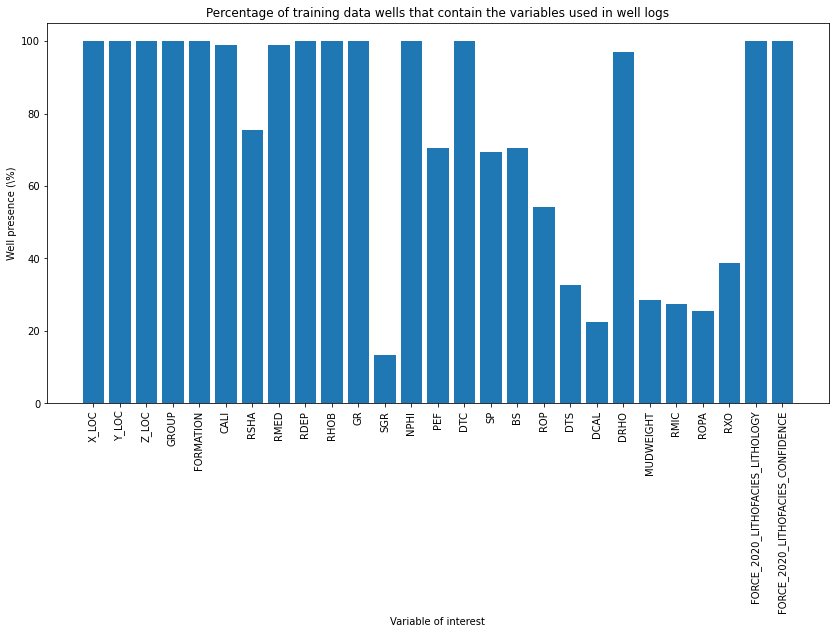

In [10]:
occurences = np.zeros(27)
for well in data['WELL'].unique():
    occurences += data[data['WELL'] == well].isna().all().astype(int).values[2:]
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(occurences.shape[0]), height=(data.WELL.unique().shape[0]-occurences)/data.WELL.unique().shape[0]*100.0)
ax.set_xticklabels(data.columns[2:], rotation=90)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Well presence (\%)')
ax.set_xlabel('Variable of interest')
ax.set_title('Percentage of training data wells that contain the variables used in well logs')
plt.show()

#### 4.2 Missing logs (Using MissingNo Module)

I tried to use the MissingNo module to see what was missing from the dataset. 

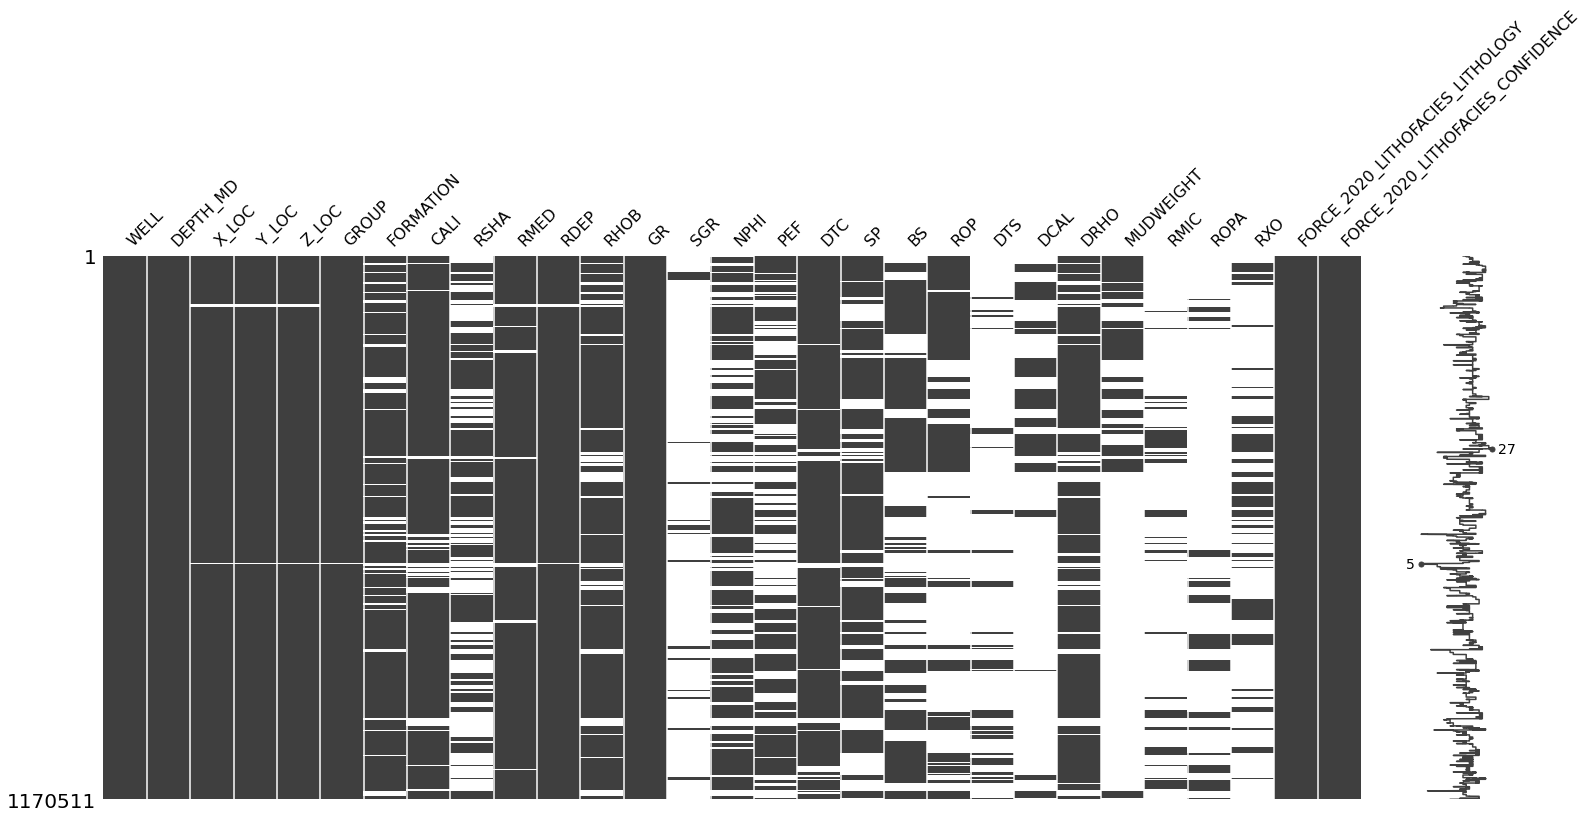

In [11]:
missingno.matrix(data)

In [12]:
# trial = pd.DataFrame(columns = ['Well','Percent Missing'])
# for well in data['WELL'].unique():
#     display(well)
#     display(data[data['WELL'] == well].isnull().sum().sum() / data[data['WELL'] == well].isnull().size)

#### 4.3 Look at some log curves for a couple of wells

In [13]:
# well_data = data[data['WELL'] == wells[0]]
# fig, axs = plt.subplots(1, len(well_data.columns)-9, figsize=(14, 10), sharey=True)
# for ic, col in enumerate(set(well_data.columns)-set(['DEPTH_MD', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
#                                                      'FORCE_2020_LITHOFACIES_CONFIDENCE', 'WELL', 'GROUP', 'FORMATION',
#                                                     'X_LOC', 'Y_LOC', 'Z_LOC'])):
#     axs[ic].plot(well_data[col], well_data['DEPTH_MD'])
#     axs[ic].set_xlabel(col)
# axs[0].set_ylim(well_data['DEPTH_MD'].values[-1], well_data['DEPTH_MD'].values[0])

In [14]:
# well_data = data[data['WELL'] == wells[57]]
# fig, axs = plt.subplots(1, len(well_data.columns)-9, figsize=(14, 10), sharey=True)
# for ic, col in enumerate(set(well_data.columns)-set(['DEPTH_MD', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
#                                                      'FORCE_2020_LITHOFACIES_CONFIDENCE', 'WELL', 'GROUP', 'FORMATION',
#                                                     'X_LOC', 'Y_LOC', 'Z_LOC'])):
#     axs[ic].plot(well_data[col], well_data['DEPTH_MD'])
#     axs[ic].set_xlabel(col)
# axs[0].set_ylim(well_data['DEPTH_MD'].values[-1], well_data['DEPTH_MD'].values[0])

#### 4.4 Well Data Box Plots

The following box plots are based on the starter notebook recommended variables. I also did a log scale of the variables to get a better sense of the data distribution.

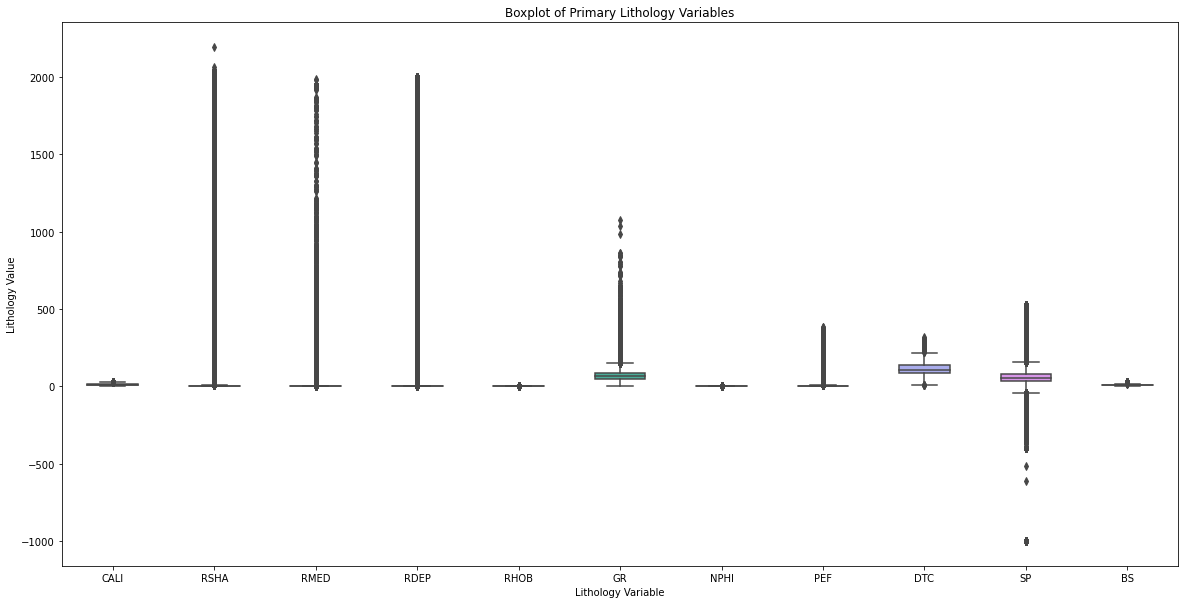

In [15]:
df_prim_boxplot = pd.melt(data[['CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS']])

plt.figure(figsize=(20,10))
ax = sns.boxplot(x=df_prim_boxplot["variable"], y=df_prim_boxplot["value"], showfliers = True, width=0.5)
ax.set(xlabel='Lithology Variable', ylabel='Lithology Value')
ax.set_title("Boxplot of Primary Lithology Variables")
plt.show()

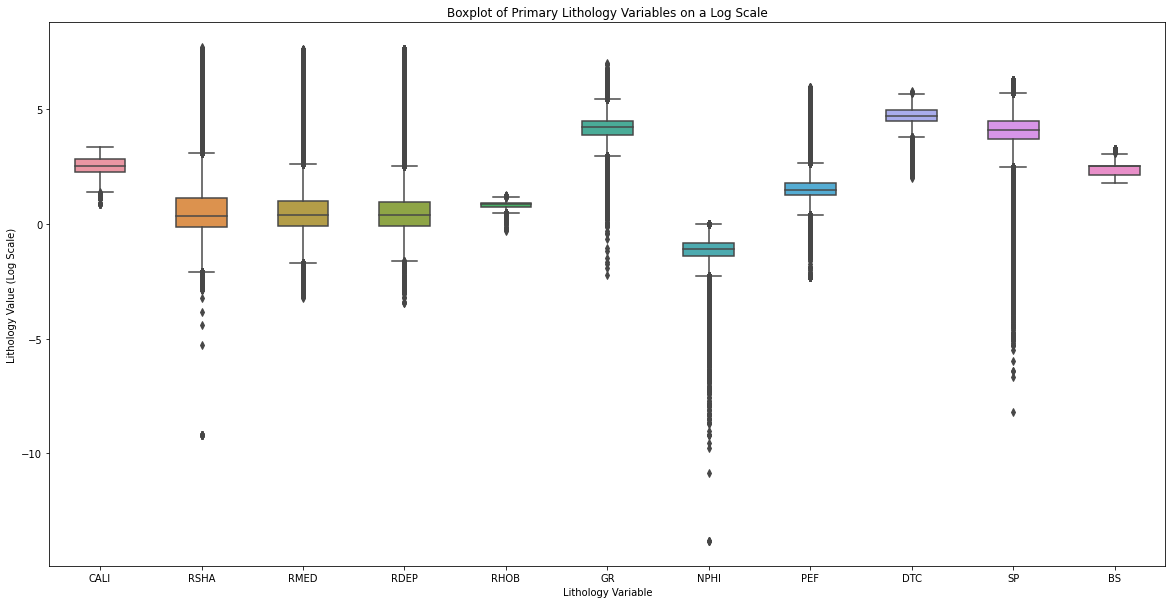

In [16]:
df_prim_log_boxplot = pd.melt(np.log(data[['CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS']])) 

plt.figure(figsize=(20,10))
ax = sns.boxplot(x=df_prim_log_boxplot["variable"], y=df_prim_log_boxplot["value"], showfliers = True, width=0.5)
ax.set(xlabel='Lithology Variable', ylabel='Lithology Value (Log Scale)')
ax.set_title("Boxplot of Primary Lithology Variables on a Log Scale")
plt.show()

Looked at the other variables that didn't have large representation in the dataset: SGR, DTC, ROP, DTS, DCAL, DRHO, RMIC, ROPA, RXO

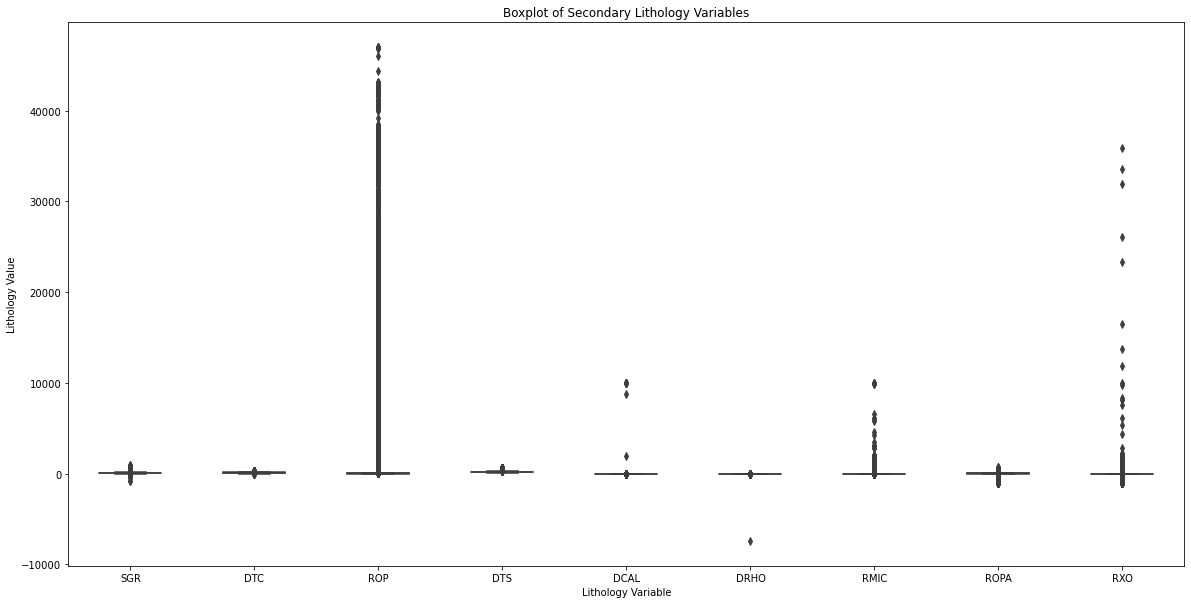

In [17]:
df_sec_boxplot = pd.melt(data[['SGR','DTC','ROP','DTS','DCAL','DRHO','RMIC','ROPA','RXO']])

plt.figure(figsize=(20,10))
ax = sns.boxplot(x=df_sec_boxplot["variable"], y=df_sec_boxplot["value"], showfliers = True, width=0.5)
ax.set(xlabel='Lithology Variable', ylabel='Lithology Value')
ax.set_title("Boxplot of Secondary Lithology Variables")
plt.show()

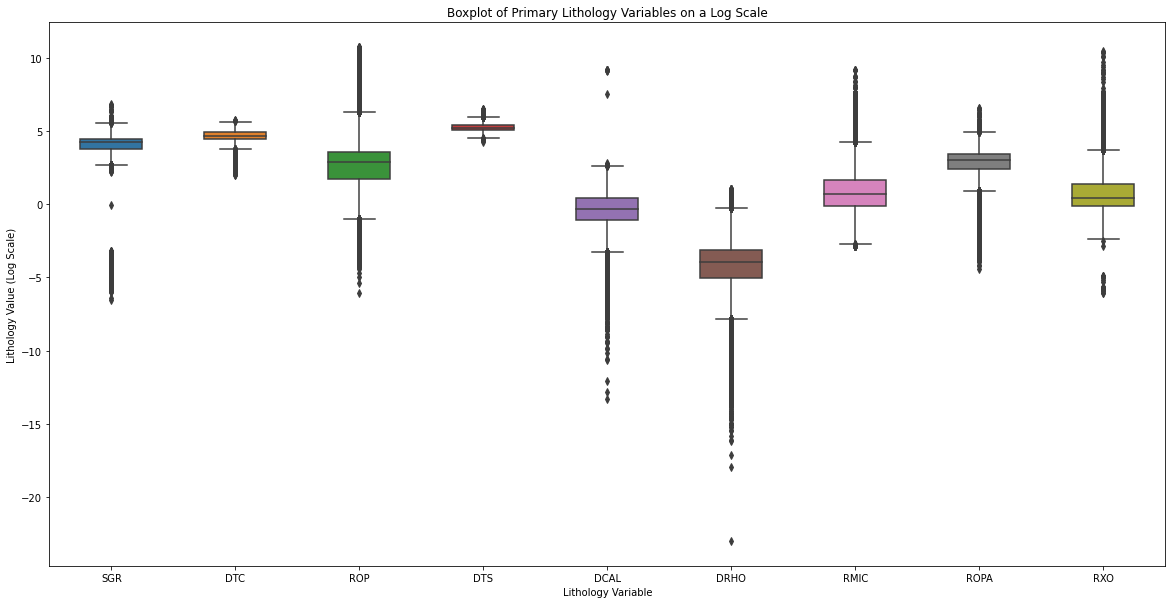

In [18]:
df_sec_log_boxplot = pd.melt(np.log(data[['SGR','DTC','ROP','DTS','DCAL','DRHO','RMIC','ROPA','RXO']]))

plt.figure(figsize=(20,10))
ax = sns.boxplot(x=df_sec_log_boxplot["variable"], y=df_sec_log_boxplot["value"], showfliers = True, width=0.5)
ax.set(xlabel='Lithology Variable', ylabel='Lithology Value (Log Scale)')
ax.set_title("Boxplot of Primary Lithology Variables on a Log Scale")
plt.show()

#### 4.5 Well Data Histograms

Below are some histograms I made of all the variables in order to see what the distribution of the values look like. Some variables, like resistivity, probably will look a lot better on a log scale.

As you can also see, I have left a link to help me remember how I made this particular loop. You will find many of these random links as I am a beginner and well on my way to learning how to use Google and Stack Overflow for almost everything.

https://stackoverflow.com/questions/50773877/create-for-loop-to-plot-histograms-for-individual-columns-of-dataframe-with-seab

In [19]:
def histograms_plot(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax)
        ax.set_title(feature+" Distribution")

    fig.tight_layout()  
    plt.show()

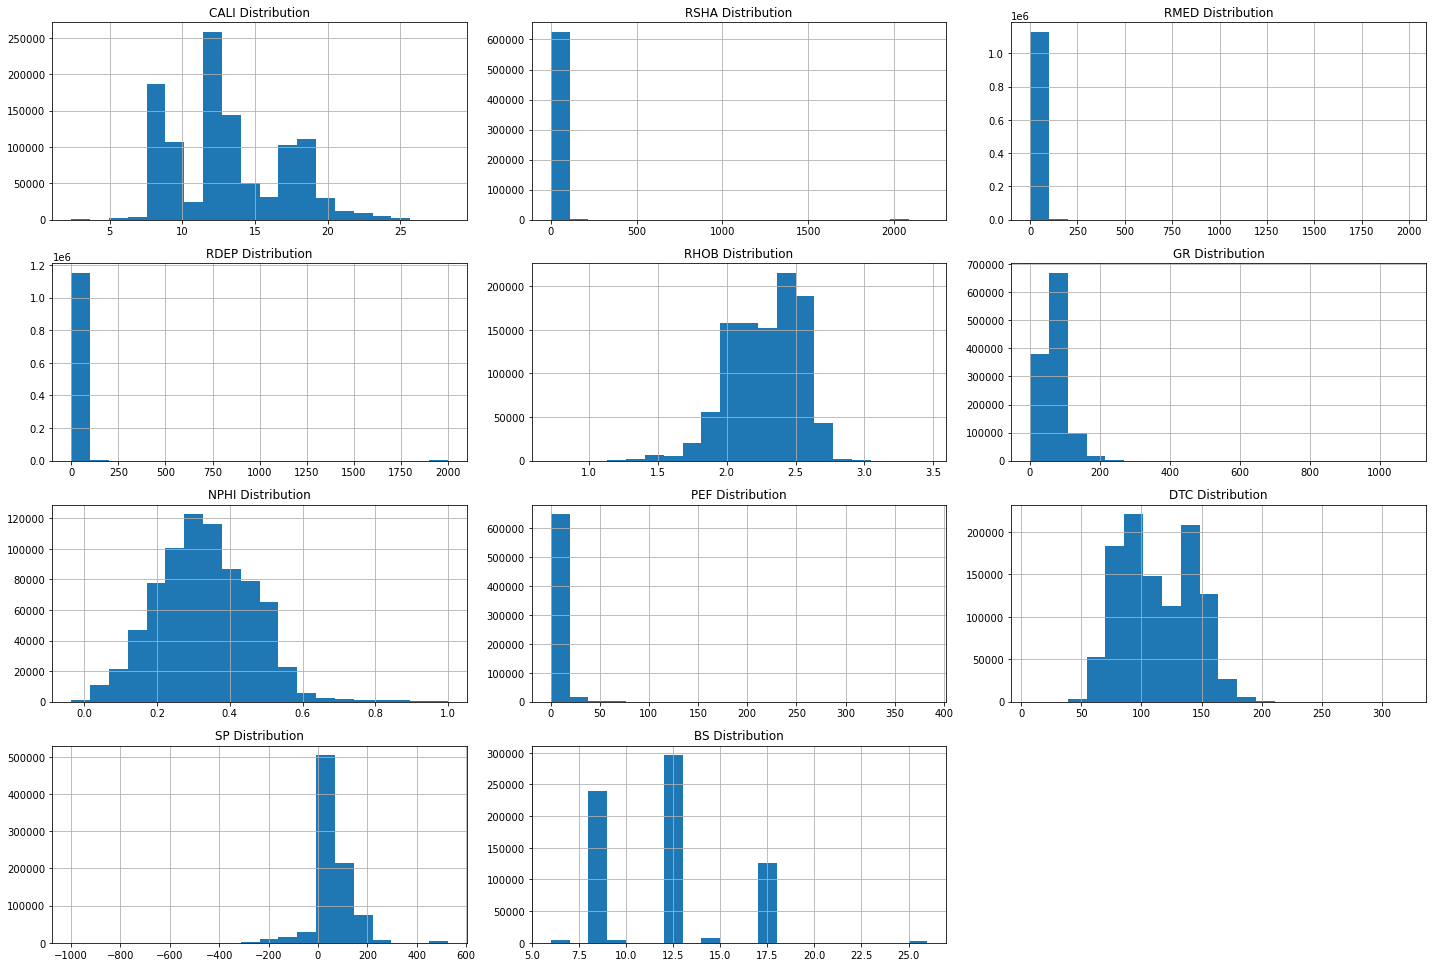

In [20]:
histograms_plot(data,data[['CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS']].columns,6,3)

The following is a repeat of the above but on a log scale for all the primary variables.

In [21]:
def histograms_log_plot(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        try:
            np.log(dataframe[feature]).hist(bins=50,ax=ax)
        except:
            pass
        ax.set_title(feature+" Distribution")

    fig.tight_layout()  
    plt.show()

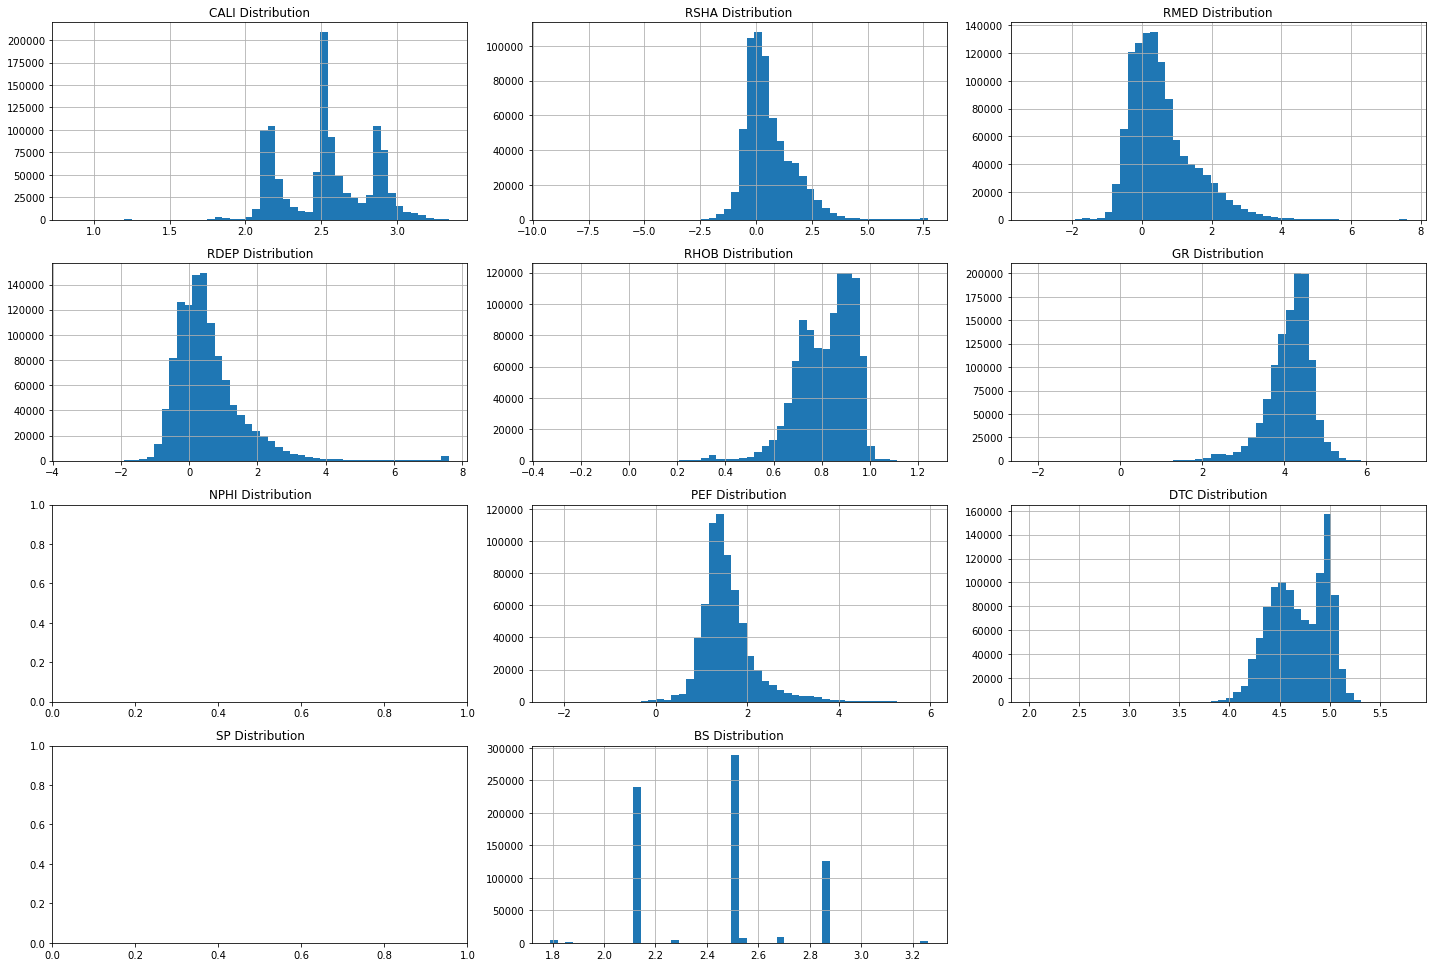

In [22]:
histograms_log_plot(data,data[['CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS']].columns,6,3)

Histogram plots for secondary variables SGR, DTC, ROP, DTS, DCAL, DRHO, RMIC, ROPA, RXO

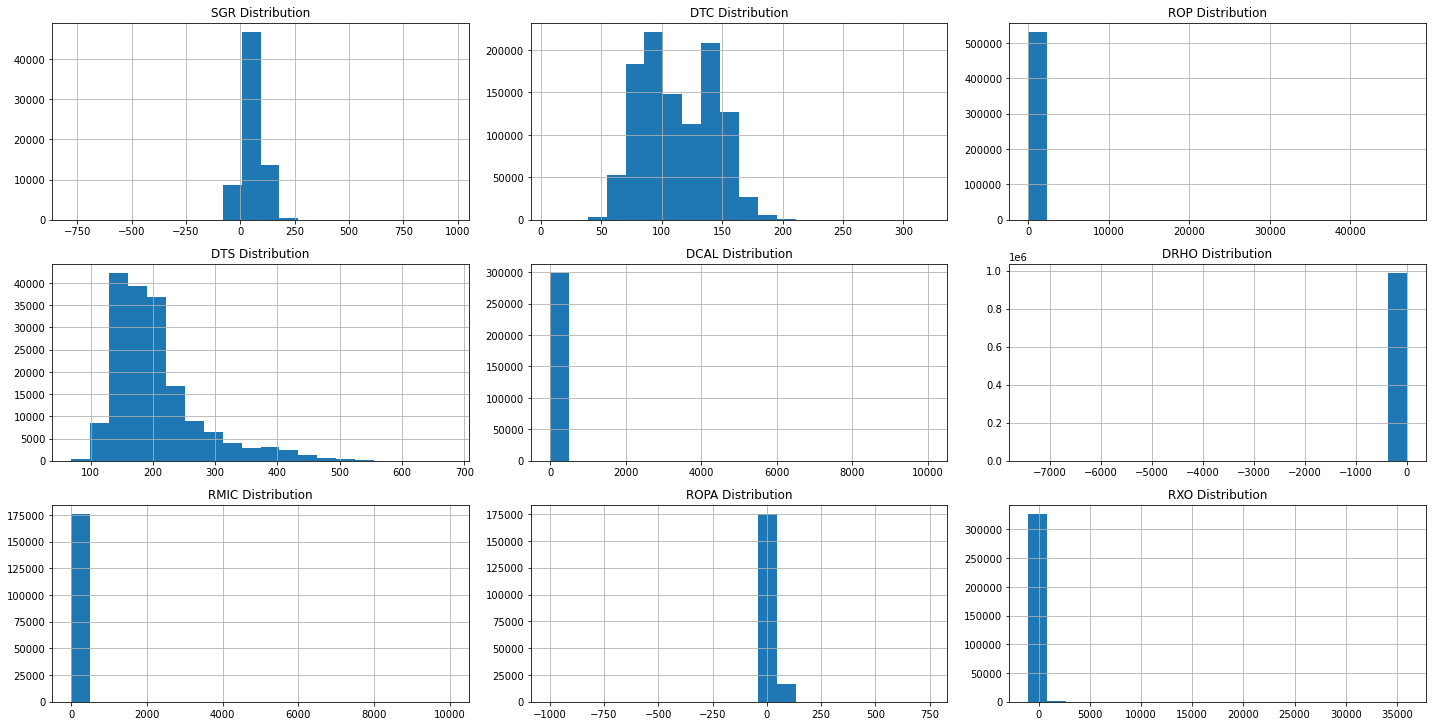

In [23]:
histograms_plot(data,data[['SGR','DTC','ROP','DTS','DCAL','DRHO','RMIC','ROPA','RXO']].columns,6,3)

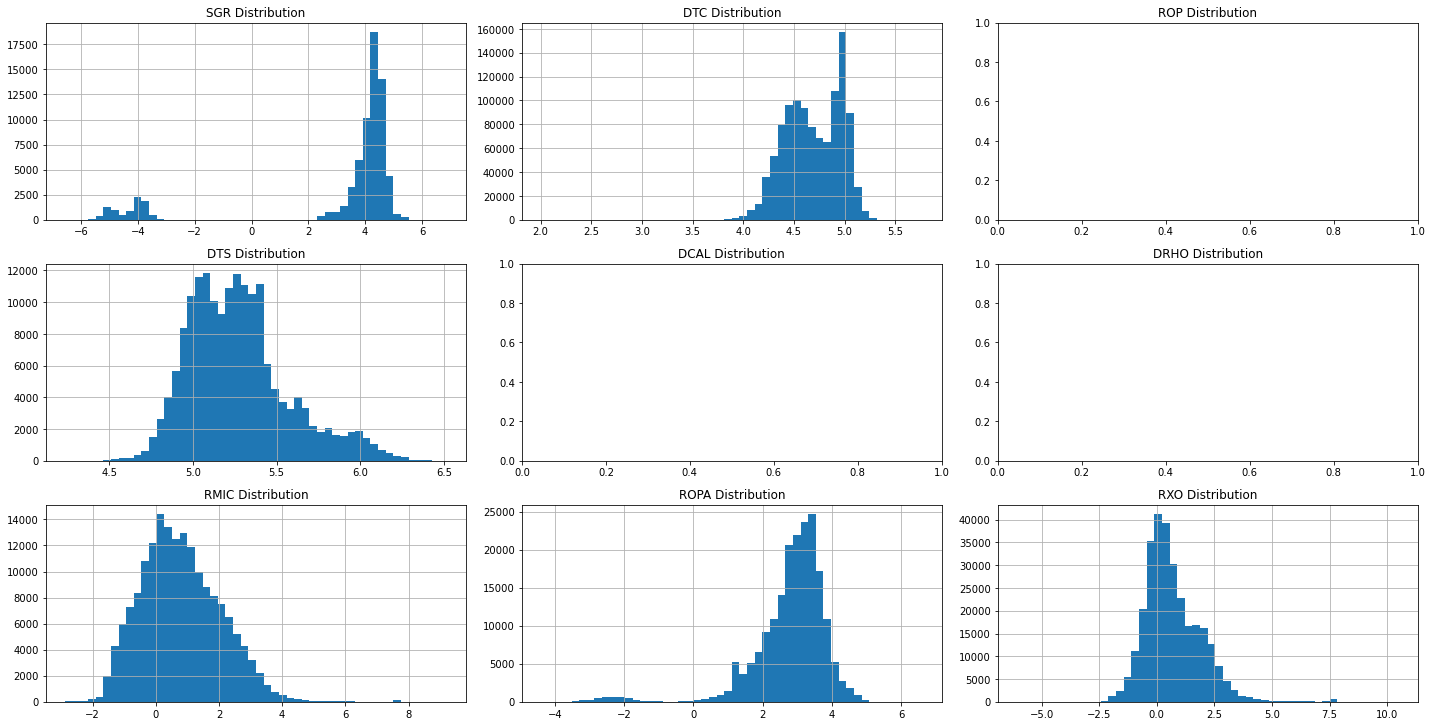

In [24]:
histograms_log_plot(data,data[['SGR','DTC','ROP','DTS','DCAL','DRHO','RMIC','ROPA','RXO']].columns,6,3)

#### 4.6 Statistical Analyses

There are certain variables that I want to take a closer look at because certain outliers will be considered not valid as they will be out of range based on discussions I have had with individuals who are petrophysicists. 

In [25]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
data[['CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS']].describe()

,CALI,RSHA,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,SP,BS
count,1082634.00,630650.00,1131518.00,1159496.00,1009242.00,1170511.00,765409.00,671692.00,1089648.00,864247.00,682657.00
mean,13.19,10.69,4.99,10.69,2.28,70.91,0.33,6.32,113.36,60.03,11.93
std,3.80,100.64,54.67,113.95,0.25,34.23,0.13,10.96,29.99,76.57,3.33
min,2.34,0.00,-0.01,0.03,0.72,0.11,-0.04,0.10,7.42,-999.00,6.00
25%,9.43,0.85,0.91,0.91,2.09,47.63,0.24,3.41,87.83,32.40,8.50
50%,12.56,1.40,1.44,1.44,2.32,68.37,0.33,4.31,109.59,55.39,12.25
75%,16.71,3.10,2.68,2.56,2.49,89.04,0.42,5.97,140.77,83.39,12.25
max,28.28,2193.90,1988.62,1999.89,3.46,1076.96,1.00,383.13,320.48,526.55,26.00


In [26]:
data[['SGR','DTC','ROP','DTS','DCAL','DRHO','RMIC','ROPA','RXO']].describe()

,SGR,DTC,ROP,DTS,DCAL,DRHO,RMIC,ROPA,RXO
count,69353.00,1089648.00,535071.00,174613.00,298833.00,987857.00,176160.00,192325.00,327427.00
mean,64.90,113.36,137.37,204.66,1.22,0.01,7.80,23.51,-95.78
std,38.44,29.99,1539.38,71.07,54.37,7.48,89.74,22.63,348.98
min,-777.99,7.42,-0.12,69.16,-12.22,-7429.34,0.06,-999.25,-999.90
25%,42.96,87.83,5.63,155.94,0.15,-0.01,0.89,11.28,0.69
50%,69.56,109.59,17.80,188.20,0.56,0.00,1.97,20.13,1.37
75%,87.91,140.77,34.81,224.65,1.30,0.02,5.08,31.14,3.42
max,963.61,320.48,47015.12,676.58,10011.42,2.84,10000.00,742.80,35930.67


### 5. Make Duplicate Data Copy

We are just going to grab a copy of the original dataset so we do not inadvertently mess up it up.

In [27]:
data1 = data.copy()

### 6. Looking at Lithology 

The following limits will be used to better capture the valid values of each variable that are being examined.
- Resistivity must be 0 or higher, and will not exceed over 2000 for RSHA, RMED, and RDEP
- Gamma Ray will not exceed over 200 for GR
- Rate of penetration ROP cannot be less than 0

Some resources on these numbers:

https://www.eoas.ubc.ca/ubcgif/iag/foundations/properties/resistivity.htm

https://wiki.aapg.org/Quick-look_lithology_from_logs

#### 6.1 Outlier Treatment

Given the above limits, some of the outliers that do not conform with the limits will be turned to NaN and then those values will be treated again later.

(This is just another link for myself https://kanoki.org/2019/07/17/pandas-how-to-replace-values-based-on-conditions/)

We are going to create a function to help us treat the outliers that do not conform to the restrictions. This will use the operator module in Python as well.

In [28]:
def outlier_removal(df, op, limit, replace):
    temp_name = df.name
    print('Before outlier removal for',df.name)
    print(df.name,'Min',min(df[df.notnull()]))
    print(df.name,'Max',max(df[df.notnull()]))
    outliers = [x for x in df if op(x,limit)]
    print('Number of',df.name,'outliers:',len(outliers),'\n')
    
    df = np.where((op(df,limit)), replace, df)
    df = pd.Series(df)
    print('After outlier removal for',temp_name)
    print(temp_name,'Min',min(df[df.notnull()]))
    print(temp_name,'Max',max(df[df.notnull()]))
    
    return df

In [29]:
# Changed any values lower than 0 on RMED to 0

data1['RMED'] = outlier_removal(data1['RMED'], operator.le, 0, np.nan)

Before outlier removal for RMED
RMED Min -0.008418695
RMED Max 1988.6163329999997
Number of RMED outliers: 7 

After outlier removal for RMED
RMED Min 0.039903767400000005
RMED Max 1988.6163329999997


In [30]:
# Changed any values from ROP that were less than 0 to 0

data1['ROP'] = outlier_removal(data1['ROP'], operator.le, 0, np.nan)

Before outlier removal for ROP
ROP Min -0.11797700800000001
ROP Max 47015.125
Number of ROP outliers: 65 

After outlier removal for ROP
ROP Min 0.0023031914999999997
ROP Max 47015.125


In [31]:
# Changed any values above 2000 on RSHA to 2000

data1['RSHA'] = outlier_removal(data1['RSHA'], operator.gt, 2000, 2000)

Before outlier removal for RSHA
RSHA Min 0.0001
RSHA Max 2193.904541
Number of RSHA outliers: 69 

After outlier removal for RSHA
RSHA Min 0.0001
RSHA Max 2000.0


In [32]:
data1['GR'] = outlier_removal(data1['GR'], operator.gt, 200, 200)

Before outlier removal for GR
GR Min 0.1092843339
GR Max 1076.9638672
Number of GR outliers: 6427 

After outlier removal for GR
GR Min 0.1092843339
GR Max 200.0


#### 6.2 Log Transforming

Some of the data looked like it better fit within a log scale.

Note: I tried using the CALI variable too but it gave me a worse result so in the end it was not log transformed.

In [33]:
## Some of the primary data fits better using the log mean.

for column in data1[['RSHA', 'RMED', 'RDEP', 'GR', 'PEF']]:
    data1[column] = np.log(data1[column])

In [34]:
## Some of the secondary data fits better using the log mean.

data1['ROP'] = np.log(data1['ROP'])
print(min(data1['ROP']))
print(max(data1['ROP']))
#data['ROP'].head(10)

-6.073459509190659
10.758224637433582


#### 6.3 Power Transform

I tried a power transformation on SP but it did not yield a better result.

https://www.listendata.com/2015/09/regression-transform-negative-values.html

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.power_transform.html

https://machinelearningmastery.com/power-transforms-with-scikit-learn/

In [35]:
# display(data['SP'])
# print(min(data['SP']))
# print(max(data['SP']))

# data['SP'].head(10)
# data['SP'].hist(bins=50)
# plt.show()

# # reshape data to have rows and columns

# temptemp = data['SP'].to_numpy()
# display(temptemp)
# temptemp = temptemp.reshape((len(temptemp),1))

# display(temptemp)
# temptemp = power_transform(temptemp, method='yeo-johnson')

# data['SP'] = temptemp
# print(min(data['SP']))
# print(max(data['SP']))
# data['SP'].hist(bins=50)
# plt.show()

#### 6.5 The LITHOLOGY column

The LITHOLOGY column contains the interpretation. Each number corresponds to a lithology class, given by the following list:

In [36]:
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

In [37]:
data1['FORCE_2020_LITHOFACIES_LITHOLOGY'].unique()

array([65000, 30000, 65030, 70000, 99000, 80000, 86000, 74000, 70032,
       90000, 88000, 93000], dtype=int64)

Lithologies are not equally likely. This is reflected in this dataset.

In [38]:
# counts = data['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()
# names = []
# percentage = []
# N = data['FORCE_2020_LITHOFACIES_LITHOLOGY'].shape[0]
# for item in counts.iteritems():
#     names.append(lithology_keys[item[0]])
#     percentage.append(float(item[1])/N*100)
# fig, ax = plt.subplots(1, 1, figsize=(14, 7))
# ax.bar(x=np.arange(len(names)), height=percentage)
# ax.set_xticklabels(names, rotation=45)
# ax.set_xticks(np.arange(len(names)))
# ax.set_ylabel('Lithology presence (\%)')

##### We should convert lithology labels to numbers 0-11 before training

In [39]:
y = data1['FORCE_2020_LITHOFACIES_LITHOLOGY']

In [40]:
lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}

In [41]:
y = y.map(lithology_numbers)

#### 6.4 Encoding

We are going to take the group and formations into account when we run our machine learning model. This was not done in the starter notebook so I thought it would be a good idea to incorporate it.

https://towardsdatascience.com/understanding-feature-engineering-part-2-categorical-data-f54324193e63

In [42]:
group = data1['GROUP'].unique()
group

array(['NORDLAND GP.', 'HORDALAND GP.', 'ROGALAND GP.', 'SHETLAND GP.',
       'CROMER KNOLL GP.', 'VIKING GP.', 'VESTLAND GP.', 'ZECHSTEIN GP.',
       'HEGRE GP.', 'ROTLIEGENDES GP.', 'TYNE GP.', 'BOKNFJORD GP.',
       'DUNLIN GP.', 'BAAT GP.', nan], dtype=object)

In [43]:
formation = data1['FORMATION'].unique()
formation

array([nan, 'Utsira Fm.', 'Balder Fm.', 'Sele Fm.', 'Lista Fm.',
       'Heimdal Fm.', 'Tor Fm.', 'Hod Fm.', 'Blodoeks Fm.', 'Svarte Fm.',
       'Roedby Fm.', 'Sola Fm.', 'Aasgard Fm.', 'Draupne Fm.',
       'Heather Fm.', 'Hugin Fm.', 'Smith Bank Fm.', 'Frigg Fm.',
       'Skagerrak Fm.', 'Ekofisk Fm.', 'Kupferschiefer Fm.', 'Skade Fm.',
       'Grid Fm.', 'Vaale Fm.', 'Sleipner Fm.', 'Hidra Fm.', 'Tuxen Fm.',
       'Mandal Fm.', 'Ula Fm.', 'Bryne Fm.', 'Tau Fm.', 'Sandnes Fm.',
       'Intra Draupne Fm. Sst.', 'Statfjord Fm.', 'Skade Mb.', 'BASEMENT',
       'Ran Sst Mb.', 'Flekkefjord Fm.', 'Sauda Fm.', 'Egersund Fm.',
       'Intra Balder Fm. Sst.', 'Hermod Mb.', 'Ty Fm.', 'Hardraade Fm.',
       'Kyrre Fm.', 'Tryggvason Fm.', 'Drake Fm.', 'Cook Fm.',
       'Amundsen Fm.', 'Grid Mb.', 'Ty Mb.', 'Jorsalfare Fm.',
       'Burton Fm.', 'Mime Fm.', 'Intra Heather Fm. Sst.', 'Tarbert Fm.',
       'Ness Fm.', 'Etive Fm.', 'Rannoch Fm.', 'Broom Fm.', 'Lunde Fm.',
       'Oseberg Fm.', 

In [44]:
formle = LabelEncoder()
formation_labels = pd.DataFrame(formle.fit_transform(data1[~data1['FORMATION'].isnull()]['FORMATION'].astype(str)))
x_form = data1[~data1['FORMATION'].isnull()]['GR'].to_numpy().reshape(-1, 1)
y_form = formation_labels.to_numpy().ravel().astype('int')

rc1 = RidgeClassifier(tol=1e-2, solver="sag")
rc1.fit(x_form, y_form)
form1 = data1.FORMATION
form_predict = rc1.predict(data1[data1['FORMATION'].isnull()]['GR'].to_numpy().reshape(-1, 1))
form1[form1.isnull()] = formle.inverse_transform(form_predict)
formation_labels = pd.DataFrame(formle.fit_transform(data1['FORMATION'].astype(str)))

In [45]:
np.unique(form_predict)

array([36, 67])

In [46]:
formation_mappings = {index: label for index, label in 
                  enumerate(formle.classes_)}
formation_mappings

{0: 'Aasgard Fm.',
 1: 'Agat Fm.',
 2: 'Amundsen Fm.',
 3: 'BASEMENT',
 4: 'Balder Fm.',
 5: 'Blodoeks Fm.',
 6: 'Broom Fm.',
 7: 'Bryne Fm.',
 8: 'Burton Fm.',
 9: 'Cook Fm.',
 10: 'Drake Fm.',
 11: 'Draupne Fm.',
 12: 'Egersund Fm.',
 13: 'Eiriksson Mb.',
 14: 'Ekofisk Fm.',
 15: 'Etive Fm.',
 16: 'Farsund Fm.',
 17: 'Fensfjord Fm.',
 18: 'Flekkefjord Fm.',
 19: 'Frigg Fm.',
 20: 'Grid Fm.',
 21: 'Grid Mb.',
 22: 'Hardraade Fm.',
 23: 'Heather Fm.',
 24: 'Heimdal Fm.',
 25: 'Hermod Mb.',
 26: 'Hidra Fm.',
 27: 'Hod Fm.',
 28: 'Hugin Fm.',
 29: 'Intra Balder Fm. Sst.',
 30: 'Intra Draupne Fm. Sst.',
 31: 'Intra Heather Fm. Sst.',
 32: 'Johansen Fm.',
 33: 'Jorsalfare Fm.',
 34: 'Krossfjord Fm.',
 35: 'Kupferschiefer Fm.',
 36: 'Kyrre Fm.',
 37: 'Lista Fm.',
 38: 'Lunde Fm.',
 39: 'Mandal Fm.',
 40: 'Mime Fm.',
 41: 'Ness Fm.',
 42: 'Oseberg Fm.',
 43: 'Ran Sst Mb.',
 44: 'Rannoch Fm.',
 45: 'Raude Mb.',
 46: 'Roedby Fm.',
 47: 'Sandnes Fm.',
 48: 'Sauda Fm.',
 49: 'Sele Fm.',
 50: 'Sk

In [47]:
gle = LabelEncoder()
group_labels = pd.DataFrame(gle.fit_transform(data1[~data1['GROUP'].isnull()]['GROUP'].astype(str)))
x_group = data1[~data1['GROUP'].isnull()]['GR'].to_numpy().reshape(-1, 1)
y_group = group_labels.to_numpy().ravel().astype('int')

rc2 = RidgeClassifier(tol=1e-2, solver="sag")
rc2.fit(x_group, y_group)
group1 = data1.GROUP
group_predict = rc2.predict(data1[data1['GROUP'].isnull()]['GR'].to_numpy().reshape(-1, 1))
group1[group1.isnull()] = gle.inverse_transform(group_predict)
group_labels = pd.DataFrame(gle.fit_transform(data1['GROUP'].astype(str)))

In [48]:
np.unique(group_predict)

array([5, 9])

In [49]:
group_mappings = {index: label for index, label in 
                  enumerate(gle.classes_)}
group_mappings

{0: 'BAAT GP.',
 1: 'BOKNFJORD GP.',
 2: 'CROMER KNOLL GP.',
 3: 'DUNLIN GP.',
 4: 'HEGRE GP.',
 5: 'HORDALAND GP.',
 6: 'NORDLAND GP.',
 7: 'ROGALAND GP.',
 8: 'ROTLIEGENDES GP.',
 9: 'SHETLAND GP.',
 10: 'TYNE GP.',
 11: 'VESTLAND GP.',
 12: 'VIKING GP.',
 13: 'ZECHSTEIN GP.'}

In [50]:
data1['GROUP_LABELS'] = group_labels

In [51]:
data1['FORMATION_LABELS'] = formation_labels

### 7. Preparing data for training

Before we drop the data, we should find the mean of the missing nans rather than apply a mean throughout the entire dataset.

In [52]:
X = data1.drop(columns=['FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORCE_2020_LITHOFACIES_CONFIDENCE'])

In [53]:
X.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
       'ROPA', 'RXO', 'GROUP_LABELS', 'FORMATION_LABELS'],
      dtype='object')

In [54]:
# X.isna().any()

#### 7.1 Imputing

In the code below, I tried to fix my code so that it could use an Iterative Imputer per unique well in order to find a better value to fill NaNs than 0. However, in running the code, the score actually got worse. I have left this here for my own knowledge.

I found a good site that helped me with imputers
https://andymdc31.github.io/missing_data_and_using_sklearns_iterativeimputer

In [55]:
# def iterimputerfix(ref_df):
#     temp_df_1 = pd.DataFrame()
#     for well in ref_df['WELL'].unique():
#         X = data1[data1['WELL'] == well]
#         for column in X:
#             if X[column].count() == 0:
#                 X[column].fillna(0, inplace=True)
#         temp_df_1 = temp_df_1.append(X, ignore_index=True)
#     return temp_df_1

In [56]:
# X = iterimputerfix(X)

In [57]:
# def well_nan_remove(ref_df):
#     """Impute each well rather than for the entire dataset.
    
#     Args:
#         ref_df (int): This is the well log dataset
    
#     Returns:
#         temp_df_1 (dataframe): The temporary dataframe made for this function
#     """
#     global X
#     temp_df_1 = pd.DataFrame()
#     for well in ref_df['WELL'].unique():
#         temp_X = X[X['WELL'] == well]
#         temp_X = temp_X.drop(columns=['WELL', 'FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORCE_2020_LITHOFACIES_CONFIDENCE', 'GROUP', 'FORMATION'])
#         #display(temp_X)
#         imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending', random_state=42)
#         imputer.fit(temp_X)
#         temp_imputer = imputer.transform(temp_X)
#         #temp_imputer = pd.DataFrame(temp_imputer)
#         temp_imputer = pd.DataFrame(temp_imputer, columns=temp_X.columns)
#         temp_df_1 = temp_df_1.append(temp_imputer, ignore_index=True)
#         #display(temp_df_1)
#     return temp_df_1

# USE CTRL + / to comment/uncomment and entire section

In [58]:
# X = well_nan_remove(X)

In [59]:
# imputer = IterativeImputer(estimator=BayesianRidge(), n_nearest_features=None, imputation_order='ascending', random_state=42)
# imputer.fit(X['GROUP_LABELS'].to_numpy().reshape(-1, 1))
# imputed = imputer.transform(X['GROUP_LABELS'].to_numpy().reshape(-1,1))
# X['GROUP_LABELS'] = imputed
# X['GROUP_LABELS']

As mentioned above, replacing NaN values with zero resulted in a better score than using imputing or using a mean average.

In [60]:
X.fillna(0, inplace=True)

##### Lithologies are not equally likely. Probably smart to take this into account by computing class weights

In [61]:
#np.bincount(y)

#### 7.2 Shuffle the data

So I tried to shuffle the data per well and that did not yield a better result

In [62]:
# def shuffle_data(ref_df):
#     global data1
#     global lithology_numbers
#     temp_df_1 = pd.DataFrame()
#     temp_y = pd.Series()
#     for well in ref_df['WELL'].unique():
#         X = ref_df[ref_df['WELL'] == well]
#         y = data1[data1['WELL'] == well]['FORCE_2020_LITHOFACIES_LITHOLOGY']
#         X = X.drop(columns=['WELL'])
#         y = y.map(lithology_numbers)
#         X, y = shuffle(X, y, random_state=42)
#         temp_df_1 = temp_df_1.append(X, ignore_index=False)
#         temp_y = temp_y.append(y, ignore_index=False)
#     return temp_df_1, temp_y

Instead I did the general shuffling of data.

In [63]:
X, y = shuffle(X, y, random_state=42)

In [64]:
X

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,GROUP_LABELS,FORMATION_LABELS
30423,15/9-15,2343.30,436806.47,6463010.50,-2318.01,ROGALAND GP.,Lista Fm.,14.88,-0.26,-0.26,-0.41,2.21,4.20,0.00,0.40,1.11,121.58,88.21,12.25,2.55,0.00,2.63,0.12,0.14,0.00,0.00,0.57,7,37
1073159,35/3-7 S,3582.47,543919.75,6856653.50,-3477.86,CROMER KNOLL GP.,Roedby Fm.,8.65,0.00,1.72,1.61,2.65,4.54,0.00,0.17,1.62,63.60,0.00,8.50,2.36,150.21,0.00,-0.01,0.00,6.63,10.41,0.00,2,46
436368,25/9-1,734.81,483545.34,6590313.00,-709.76,NORDLAND GP.,Utsira Fm.,0.00,0.00,0.00,0.00,0.00,4.02,0.00,0.00,0.00,0.00,0.00,17.50,4.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6,67
290688,25/3-1,1075.97,487291.25,6643945.00,-1053.94,HORDALAND GP.,Utsira Fm.,17.65,0.00,-0.14,0.21,2.04,3.73,0.00,0.00,-0.26,148.78,21.60,17.50,2.08,0.00,0.22,0.05,0.96,0.00,0.00,0.00,5,67
1118085,35/9-10 S,3580.06,537897.75,6791142.50,-3069.18,BAAT GP.,Rannoch Fm.,8.57,0.00,2.03,2.09,2.57,4.84,0.00,0.26,1.29,77.51,0.00,8.50,3.46,140.67,0.00,0.04,0.00,0.00,0.00,0.00,0,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,16/11-1 ST3,2619.55,0.00,0.00,0.00,ZECHSTEIN GP.,Smith Bank Fm.,12.44,0.00,0.00,0.00,0.00,1.81,0.00,0.00,0.00,68.53,0.00,12.25,0.87,0.00,0.00,0.00,1.43,0.00,0.00,0.00,13,54
259178,25/2-14,3032.06,476870.34,6625402.00,-3008.02,VIKING GP.,Draupne Fm.,12.15,0.66,0.27,0.29,2.34,5.18,0.00,0.67,1.46,121.56,58.38,12.25,0.00,0.00,-0.10,0.04,0.00,0.00,0.00,0.00,12,11
131932,16/2-16,2015.64,476768.28,6523588.50,-1989.27,HEGRE GP.,Skagerrak Fm.,8.53,0.00,0.49,0.48,2.47,4.39,0.00,0.23,1.22,89.30,0.00,8.50,2.20,172.16,0.00,-0.00,0.00,0.00,0.00,0.00,4,52
671155,31/5-4 S,1424.41,530753.69,6732068.00,-1380.43,ROGALAND GP.,Lista Fm.,0.00,0.00,0.00,-0.55,0.00,4.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7,37


#### Select only the columns you want to use

In [65]:
X.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
       'ROPA', 'RXO', 'GROUP_LABELS', 'FORMATION_LABELS'],
      dtype='object')

### 8. Final Cleanup

#### Reselect only the columns you want to use after doing some feature engineering

For this, I also used ROP since it did show some importance relative to all the other variables.

In [67]:
#X = X[['X_LOC', 'Y_LOC', 'Z_LOC', 'DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'GROUP_LABELS', 'FORMATION_LABELS']]
X = X[['X_LOC', 'Y_LOC', 'Z_LOC', 'DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'GROUP_LABELS', 'FORMATION_LABELS', 'ROP']]

# DID USE ROP!
# Did not use SGR, RMIC, ROPA, RXO, DRHO, DCAL, DTS

##### Scale the features

In [68]:
scaler = StandardScaler()

In [69]:
X.columns

Index(['X_LOC', 'Y_LOC', 'Z_LOC', 'DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP',
       'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'GROUP_LABELS',
       'FORMATION_LABELS', 'ROP'],
      dtype='object')

In [70]:
X = scaler.fit_transform(X)

##### Split into train and test data

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 9. Applying the custom scoring function

Apart from the missing log curves, **one of the key challenges of this machine learning competition is that you are being scored using a custom scoring function**. 

A prediction is scored using the penalty function
$$ S = - \frac{1}{N}\sum_{i=0}^N A_{ \hat{y}_i y_i} $$
where $N$ is the number of samples, $y_i$ is prediction for sample $i$, $\hat{y}_i$ is the true target for sample $i$, and $A$ is the penalty matrix given by the following

In short, the value of the matrix A at row i and column j is the **penalty** given by guessing lithology number i when the correct label is lithology numner j. Notice that the diagonal consists of zeros, no penalty is given for correct predictions.

In [72]:
A = np.load('penalty_matrix.npy')

In [73]:
A

array([[0.   , 2.   , 3.5  , 3.   , 3.75 , 3.5  , 3.5  , 4.   , 4.   ,
        2.5  , 3.875, 3.25 ],
       [2.   , 0.   , 2.375, 2.75 , 4.   , 3.75 , 3.75 , 3.875, 4.   ,
        3.   , 3.75 , 3.   ],
       [3.5  , 2.375, 0.   , 2.   , 3.5  , 3.5  , 3.75 , 4.   , 4.   ,
        2.75 , 3.25 , 3.   ],
       [3.   , 2.75 , 2.   , 0.   , 2.5  , 2.   , 2.25 , 4.   , 4.   ,
        3.375, 3.75 , 3.25 ],
       [3.75 , 4.   , 3.5  , 2.5  , 0.   , 2.625, 2.875, 3.75 , 3.25 ,
        3.   , 4.   , 3.625],
       [3.5  , 3.75 , 3.5  , 2.   , 2.625, 0.   , 1.375, 4.   , 3.75 ,
        3.5  , 4.   , 3.625],
       [3.5  , 3.75 , 3.75 , 2.25 , 2.875, 1.375, 0.   , 4.   , 3.75 ,
        3.125, 4.   , 3.75 ],
       [4.   , 3.875, 4.   , 4.   , 3.75 , 4.   , 4.   , 0.   , 2.75 ,
        3.75 , 3.75 , 4.   ],
       [4.   , 4.   , 4.   , 4.   , 3.25 , 3.75 , 3.75 , 2.75 , 0.   ,
        4.   , 4.   , 3.875],
       [2.5  , 3.   , 2.75 , 3.375, 3.   , 3.5  , 3.125, 3.75 , 4.   ,
        0.   , 2.5  

The scoring function can be implemented as follows. If used as a loss function in a neural network framwork, it is recommended to implement a more efficient function based on tensor products. 

In [74]:
def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

**IMPORTANT: The implementation above assumes zero-indexed y_true and y_pred. Be careful not to mix zero-indexed and 1-indexed class labels.**

Let us see what happens when we test the scoring function on some corner cases:

##### Lazily guessing SHALE for everything gives an OK score due to the imbalance of the dataset

In [75]:
score(y_test.values, np.ones(y_test.shape)*2)

-1.154113253567874

##### Doing the same for an uncommon class, like COAL, not so much..

In [76]:
score(y_test.values, np.ones(y_test.shape)*11)

-3.0950906225037698

##### Of course getting it completely right gives the highest possible score, 0

In [77]:
score(y_test.values, y_test.values)

0.0

### 10. Example prediction on open test dataset

I used RandomForestClassifer as suggested as a starter to do this particular challenge. 

Some notes from the organizers were made about using Random Forest:

*Apart from the inherent flaws of the random forest classifier, this example approach has a number of issues and simplifications. For example:*
* *Data is not separated per well. Normalization and shuffling is done across the whole dataset.*
##### JZ comment: I had tried to shuffle the data per well but it did not give a better result.
* *The penatly matrix is not taken into account, it is treated as a normal classification problem.*
##### JZ comment: For some reason my computer did not like using the penalty matrix as part of the scoring
* *Missing logs are treated as zeros* 
##### JZ comment: Already discussed. Zeros yield a better result than imputing or filling in a mean (per well) for some reason
* *Depth and formation tops not taken into account*
##### JZ comment: Categorical group and formation have now been taken into account
* *Same model is used for when you only have gamma ray logs as when you have the full set of logs*
##### JZ comment: I did not know enough about lithologies to make changes based on this comment.

Here, I could have used a pipeline but I am still a beginner, so I've just done it step by step.

In [78]:
model = RandomForestClassifier(random_state=42, class_weight='balanced')

##### GridSearchCV

In [79]:
param_grid = [
{'n_estimators': [200]}
]

In [80]:
#model = GridSearchCV(model, param_grid, cv=3, scoring=make_scorer(score, greater_is_better=True), n_jobs=-1)
model = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [81]:
# Timing of training
start_time = time.time()

# Actual training line
model.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 2848.865264892578 seconds ---


#### Test model

In [82]:
#y_pred_test = model.predict(X_test)

y_pred_test = model.best_estimator_.predict(X_test)

In [83]:
#model.best_params_

In [84]:
score(y_test.values, y_pred_test)

-0.1014083544422754

### Testing Blind Data

In [85]:
open_test_features = pd.read_csv(r'test.csv', sep=';')

In [86]:
open_test_features.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO
0,15/9-14,480.63,423244.50,6461862.50,-455.62,NORDLAND GP.,NaN,19.20,nan,1.61,1.51,2.17,72.08,nan,0.55,55.82,174.35,35.53,nan,96.46,nan,nan,-0.54,0.13,nan,nan,nan
1,15/9-14,480.78,423244.50,6461862.50,-455.78,NORDLAND GP.,NaN,19.20,nan,1.57,1.48,2.17,72.15,nan,0.55,41.86,176.11,36.16,nan,96.45,nan,nan,-0.54,0.13,nan,nan,nan
2,15/9-14,480.93,423244.50,6461862.50,-455.93,NORDLAND GP.,NaN,19.20,nan,1.44,1.47,2.16,75.07,nan,0.55,38.59,177.66,36.87,nan,96.45,nan,nan,-0.54,0.13,nan,nan,nan
3,15/9-14,481.08,423244.50,6461862.50,-456.08,NORDLAND GP.,NaN,19.20,nan,1.28,1.47,2.15,80.74,nan,0.55,41.42,177.44,37.30,nan,161.17,nan,nan,-0.54,0.13,nan,nan,nan
4,15/9-14,481.24,423244.53,6461862.50,-456.23,NORDLAND GP.,NaN,19.20,nan,1.20,1.47,2.14,81.67,nan,0.57,49.47,176.80,37.86,nan,172.49,nan,nan,-0.54,0.13,nan,nan,nan


In [87]:
test_wells = open_test_features['WELL'].unique().tolist()

In [88]:
test_wells

['15/9-14',
 '25/10-10',
 '25/11-24',
 '25/5-3',
 '29/3-1',
 '34/10-16 R',
 '34/3-3 A',
 '34/6-1 S',
 '35/6-2 S',
 '35/9-8']

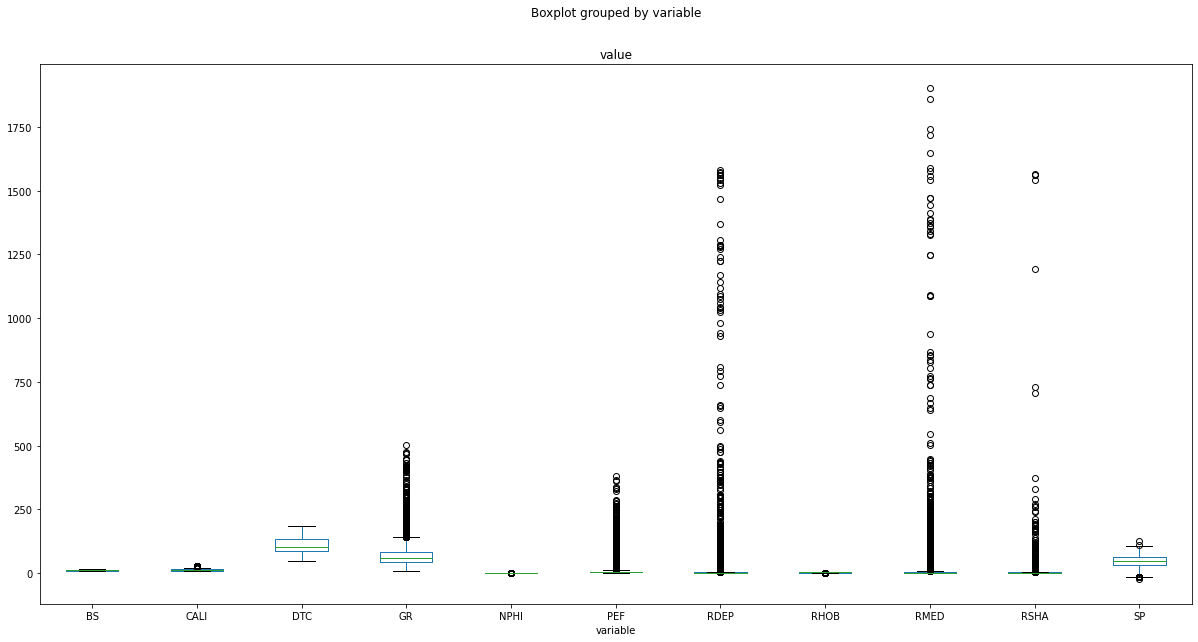

In [89]:
pd.melt(open_test_features[['CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS']]).boxplot(by ='variable', column =['value'], 
                                                                                                        grid = False, figsize=(20,10), 
                                                                                                        showfliers=True) 
plt.show()

In [90]:
test_formation = open_test_features['FORMATION'].unique()
test_formation

array([nan, 'Utsira Fm.', 'Balder Fm.', 'Sele Fm.', 'Lista Fm.',
       'Heimdal Fm.', 'Ty Fm.', 'Ekofisk Fm.', 'Tor Fm.', 'Hod Fm.',
       'Blodoeks Fm.', 'Svarte Fm.', 'Roedby Fm.', 'Sola Fm.',
       'Aasgard Fm.', 'Draupne Fm.', 'Heather Fm.', 'Hugin Fm.',
       'Sleipner Fm.', 'Skagerrak Fm.', 'Smith Bank Fm.', 'Skade Fm.',
       'Grid Fm.', 'Intra Balder Fm. Sst.', 'Statfjord Fm.', 'Vaale Fm.',
       'Hardraade Fm.', 'Drake Fm.', 'Burton Fm.', 'Jorsalfare Fm.',
       'Kyrre Fm.', 'Tryggvason Fm.', 'Tarbert Fm.', 'Ness Fm.',
       'Etive Fm.', 'Rannoch Fm.', 'Cook Fm.', 'Amundsen Fm.',
       'Lunde Fm.', 'Mime Fm.', 'Agat Fm.', 'Intra Heather Fm. Sst.'],
      dtype=object)

In [91]:
test_group = open_test_features['GROUP'].unique()
test_group

array(['NORDLAND GP.', 'HORDALAND GP.', 'ROGALAND GP.', 'SHETLAND GP.',
       'CROMER KNOLL GP.', 'VIKING GP.', 'VESTLAND GP.', 'ZECHSTEIN GP.',
       'DUNLIN GP.', 'BAAT GP.', 'HEGRE GP.'], dtype=object)

In [92]:
# form_test_le = LabelEncoder()
# formation_test_labels = pd.DataFrame(form_test_le.fit_transform(open_test_features[~open_test_features['FORMATION'].isnull()]['FORMATION'].astype(str)))
# x_test_form = y[~data1['FORMATION'].isnull()].to_numpy().reshape(-1, 1)
# y_form = formation_labels.to_numpy().ravel().astype('int')

# rc = RidgeClassifier(tol=1e-2, solver="sag")
# rc.fit(x_form, y_form)

form_test1 = open_test_features.FORMATION
form_test_predict = rc1.predict(open_test_features[open_test_features['FORMATION'].isnull()]['GR'].to_numpy().reshape(-1, 1))
form_test1[form_test1.isnull()] = formle.inverse_transform(form_test_predict)

In [93]:
np.unique(form_test_predict)

array([23])

In [94]:
test_formation = {value : key for (key, value) in formation_mappings.items()}

In [95]:
test_formation

{'Aasgard Fm.': 0,
 'Agat Fm.': 1,
 'Amundsen Fm.': 2,
 'BASEMENT': 3,
 'Balder Fm.': 4,
 'Blodoeks Fm.': 5,
 'Broom Fm.': 6,
 'Bryne Fm.': 7,
 'Burton Fm.': 8,
 'Cook Fm.': 9,
 'Drake Fm.': 10,
 'Draupne Fm.': 11,
 'Egersund Fm.': 12,
 'Eiriksson Mb.': 13,
 'Ekofisk Fm.': 14,
 'Etive Fm.': 15,
 'Farsund Fm.': 16,
 'Fensfjord Fm.': 17,
 'Flekkefjord Fm.': 18,
 'Frigg Fm.': 19,
 'Grid Fm.': 20,
 'Grid Mb.': 21,
 'Hardraade Fm.': 22,
 'Heather Fm.': 23,
 'Heimdal Fm.': 24,
 'Hermod Mb.': 25,
 'Hidra Fm.': 26,
 'Hod Fm.': 27,
 'Hugin Fm.': 28,
 'Intra Balder Fm. Sst.': 29,
 'Intra Draupne Fm. Sst.': 30,
 'Intra Heather Fm. Sst.': 31,
 'Johansen Fm.': 32,
 'Jorsalfare Fm.': 33,
 'Krossfjord Fm.': 34,
 'Kupferschiefer Fm.': 35,
 'Kyrre Fm.': 36,
 'Lista Fm.': 37,
 'Lunde Fm.': 38,
 'Mandal Fm.': 39,
 'Mime Fm.': 40,
 'Ness Fm.': 41,
 'Oseberg Fm.': 42,
 'Ran Sst Mb.': 43,
 'Rannoch Fm.': 44,
 'Raude Mb.': 45,
 'Roedby Fm.': 46,
 'Sandnes Fm.': 47,
 'Sauda Fm.': 48,
 'Sele Fm.': 49,
 'Skade 

In [96]:
test_group = {value : key for (key, value) in group_mappings.items()}

In [97]:
test_group

{'BAAT GP.': 0,
 'BOKNFJORD GP.': 1,
 'CROMER KNOLL GP.': 2,
 'DUNLIN GP.': 3,
 'HEGRE GP.': 4,
 'HORDALAND GP.': 5,
 'NORDLAND GP.': 6,
 'ROGALAND GP.': 7,
 'ROTLIEGENDES GP.': 8,
 'SHETLAND GP.': 9,
 'TYNE GP.': 10,
 'VESTLAND GP.': 11,
 'VIKING GP.': 12,
 'ZECHSTEIN GP.': 13}

In [98]:
open_test_features['GROUP_LABELS'] = open_test_features['GROUP'].astype(str).map(test_group)

In [99]:
open_test_features['FORMATION_LABELS'] = open_test_features['FORMATION'].astype(str).map(test_formation)

In [100]:
open_test_features['GROUP'].isna().sum()

0

In [101]:
open_test_features['FORMATION'].isna().sum()

0

In [102]:
open_test_features['FORMATION_LABELS'].isna().sum()

0

In [103]:
open_test_features.isna().sum()

WELL                     0
DEPTH_MD                 0
X_LOC                   59
Y_LOC                   59
Z_LOC                   59
GROUP                    0
FORMATION                0
CALI                  5645
RSHA                 97689
RMED                   587
RDEP                    59
RHOB                 16960
GR                       0
SGR                 136786
NPHI                 32743
PEF                  23283
DTC                    823
SP                   70159
BS                   69822
ROP                  68470
DTS                  93566
DCAL                123271
DRHO                 25230
MUDWEIGHT           116517
RMIC                125470
ROPA                 80996
RXO                 106938
GROUP_LABELS             0
FORMATION_LABELS         0
dtype: int64

In [104]:
open_test_features.sample(10)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,GROUP_LABELS,FORMATION_LABELS
112114,34/3-3 A,4930.96,486173.75,6853265.00,-3893.57,DUNLIN GP.,Cook Fm.,8.66,nan,0.85,0.84,2.21,47.35,nan,0.33,7.04,82.94,nan,8.50,22.32,167.14,nan,0.00,nan,nan,22.98,nan,3,9
19895,15/9-14,3506.04,423279.16,6461834.50,-3479.55,VESTLAND GP.,Skagerrak Fm.,8.38,1.23,0.59,0.48,2.29,33.87,nan,0.25,nan,90.12,34.07,nan,14.83,nan,nan,-0.02,0.17,nan,nan,1.18,11,52
77705,34/10-16 R,1499.84,455758.00,6773611.50,-1477.83,HORDALAND GP.,Utsira Fm.,16.48,1.41,0.74,0.75,2.08,19.28,nan,nan,12.89,122.12,56.43,nan,nan,nan,nan,0.01,nan,nan,nan,1.41,5,67
43279,25/5-3,2595.09,479092.97,6605456.50,-2572.95,DUNLIN GP.,Burton Fm.,8.60,nan,3.86,3.00,2.54,92.58,nan,0.33,4.27,89.24,1.82,8.50,nan,nan,nan,0.01,nan,nan,nan,nan,3,8
34838,25/5-3,1312.06,479084.41,6605460.00,-1289.99,HORDALAND GP.,Skade Fm.,13.14,nan,1.49,1.54,2.11,65.25,nan,nan,4.11,142.66,-2.67,12.25,nan,nan,nan,0.00,nan,nan,nan,nan,5,50
82921,34/10-16 R,2292.67,455758.59,6773613.00,-2270.62,SHETLAND GP.,Jorsalfare Fm.,14.26,1.76,1.29,1.25,2.34,62.01,nan,0.38,2.93,113.06,75.44,nan,nan,nan,nan,0.01,nan,nan,nan,1.76,9,33
136182,35/9-8,3094.13,536229.38,6794883.50,-3069.69,VIKING GP.,Heather Fm.,8.53,nan,5.47,5.68,2.60,121.09,nan,0.33,3.27,80.85,nan,8.50,18.21,153.35,nan,-0.01,nan,5.03,16.09,nan,12,23
19715,15/9-14,3478.68,423277.72,6461835.00,-3452.23,VESTLAND GP.,Skagerrak Fm.,8.46,3.26,1.39,0.94,2.32,29.17,nan,0.22,nan,76.03,37.66,nan,7.39,nan,nan,-0.04,0.17,nan,nan,3.73,11,52
6157,15/9-14,1417.86,423243.25,6461867.00,-1392.81,HORDALAND GP.,Utsira Fm.,15.14,nan,1.16,1.20,2.00,64.62,nan,0.47,2.06,142.99,24.08,nan,14.66,nan,nan,0.02,0.14,nan,nan,nan,5,67
134627,35/9-8,2857.77,536234.19,6794888.50,-2833.45,VIKING GP.,Intra Heather Fm. Sst.,8.53,nan,1.58,1.83,2.30,69.67,nan,0.21,3.23,82.85,nan,8.50,nan,154.77,nan,0.00,nan,0.56,9.00,nan,12,31


In [105]:
open_test_features['RMED'] = np.where((open_test_features.RMED <= 0), np.nan, open_test_features.RMED)
open_test_features['RMED'] = np.where((open_test_features.RMED > 2000), 2000, open_test_features.RMED)

open_test_features['RSHA'] = np.where((open_test_features.RSHA <= 0), np.nan, open_test_features.RSHA)
open_test_features['RSHA'] = np.where((open_test_features.RSHA > 2000), np.nan, open_test_features.RSHA)

open_test_features['RDEP'] = np.where((open_test_features.RDEP <= 0), np.nan, open_test_features.RDEP)
open_test_features['RDEP'] = np.where((open_test_features.RDEP > 2000), np.nan, open_test_features.RDEP)

open_test_features['GR'] = np.where((open_test_features.GR > 200), 200, open_test_features.GR)

## Fix outlier issue for ROP

m4 = open_test_features[open_test_features['ROP'] < 0]
open_test_features['ROP'] = np.where((open_test_features.ROP <= 0), np.nan, open_test_features.ROP)

## Some of the data fits better using the log mean.
for column in open_test_features[['RSHA', 'RMED', 'RDEP', 'GR', 'PEF']]:
    open_test_features[column] = np.log(open_test_features[column])

# Log scale for ROP

open_test_features['ROP'] = np.log(open_test_features['ROP'])

open_test_features.fillna(0, inplace=True)
open_test_features = open_test_features[['X_LOC', 'Y_LOC', 'Z_LOC', 'DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'GROUP_LABELS', 'FORMATION_LABELS', 'ROP']]
open_test_features = scaler.transform(open_test_features)
test_prediction = model.predict(open_test_features)
display(test_prediction)
category_to_lithology = {y:x for x,y in lithology_numbers.items()}
test_prediction_for_submission = np.vectorize(category_to_lithology.get)(test_prediction)
display(test_prediction_for_submission)
np.savetxt('test_predictions_10_26_2020.csv', test_prediction_for_submission, header='lithology', comments='', fmt='%i')

array([2, 2, 2, ..., 0, 0, 0], dtype=int64)

array([65000, 65000, 65000, ..., 30000, 30000, 30000])

### Submitting code for final scoring
Commentes below from organizer for submitting final code:

*At the end of the competition, the highest performing teams are invited to submit code for blind scoring on a hidden test dataset. The winner will be the team with the best score on the hidden test dataset, not the weekly leaderboard. In order to do this, you must submit the following in a zip-file:*
* *Code to do the inference*
* *Any persisted data in the form of pre-trained model or models, scalers, and more*
* *Information about your environment*

*There are many ways of doing this. In the example above, the code to do the inference would be the `Model` class in a python-file, the persisted data would be the files `model.pkl` and `scaler.pkl`.* 

*Your python environment needs to be replicable by the judges of the competition. There are many ways of doing this. Examples include dumping pip package versions to a file*

In [106]:
!pip freeze > requirements_10_26_2020.txt

If you are using Anaconda, then you can export an envionment file as follows

In [107]:
!conda env export > environment_10_26_2020.yml

Other options include `Docker`, `pipenv` and many more.